In [27]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt 
import os
import cv2

In [17]:
# Load iris dataset
iris_data = load_iris()
data = iris_data.data
target = iris_data.target
#print(target)
print(iris_data.target_names)
print(iris_data.feature_names)
print(data.shape)
target = target.reshape((150, 1))
labelled_data = np.hstack((data, target))
#print(labelled_data.shape)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(150, 4)
(150, 5)


In [20]:
# Shuffle iris dataset
np.random.shuffle(labelled_data)
print(labelled_data[:10,:])
shuffled_data = labelled_data[:, :4]
shuffled_target = labelled_data[:, 4]
#print(shuffled_data[:10])
#print(shuffled_target[:10])

[[5.6 2.7 4.2 1.3 1. ]
 [4.4 2.9 1.4 0.2 0. ]
 [5.6 2.8 4.9 2.  2. ]
 [5.  2.  3.5 1.  1. ]
 [5.8 2.7 3.9 1.2 1. ]
 [5.7 2.5 5.  2.  2. ]
 [6.5 3.2 5.1 2.  2. ]
 [7.2 3.2 6.  1.8 2. ]
 [6.6 3.  4.4 1.4 1. ]
 [5.7 2.9 4.2 1.3 1. ]]


## Incremental Clustering: Intrusion Detection

In [28]:
# Initialize mean and variance images
def initBackground(initImage):
    img_arr = plt.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return(mean,variance)

In [31]:
# Use Chebyshev inequality based classifier for intrusion detection
def ForegroundDetection(img_file,mean,variance,lmda):
    img = plt.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

In [32]:
# Reduce Image noise using voting scheme
def Voting(rI,eta,m,n):
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n:
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

In [33]:
# Update mean and variance
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = plt.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)
            else:
                mean_upd[i,j,:] = M[i,j,:]
                var_upd[i,j,:] = V[i,j,:]
    return(mean_upd,var_upd)

In [36]:
def Background_Subtraction(img_dir,lmda,eta,m,n,alpha):
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(1,len(img_file_name)):
        img_path = os.path.join(img_dir,img_file_name[i])
        
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)
        ax[1].imshow(cI,cmap="gray")
        
        img = plt.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()

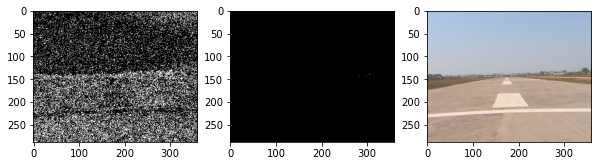

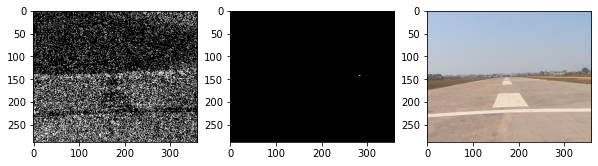

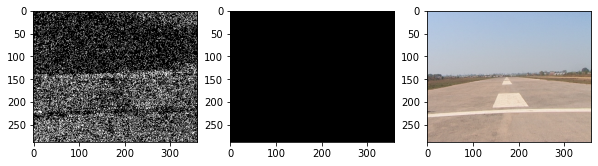

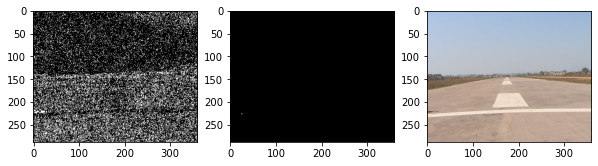

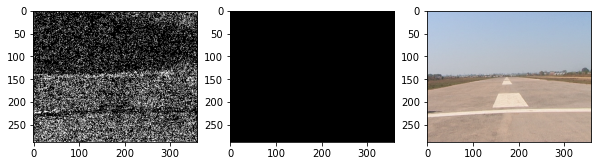

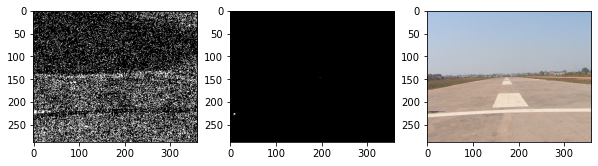

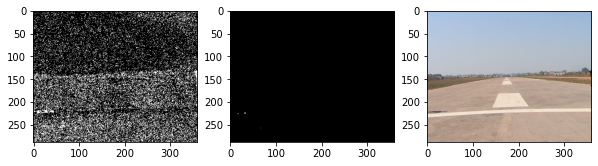

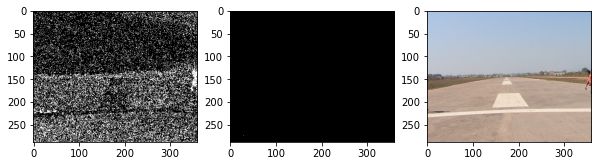

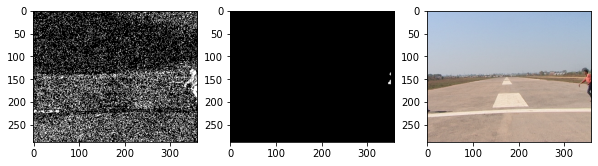

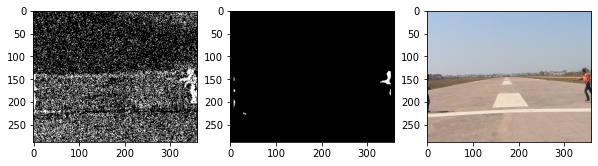

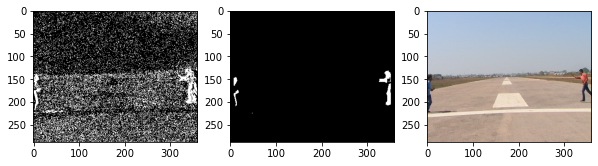

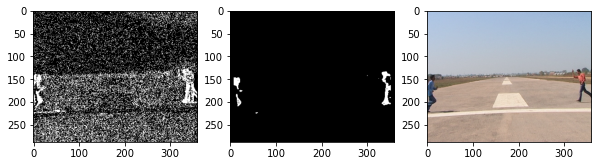

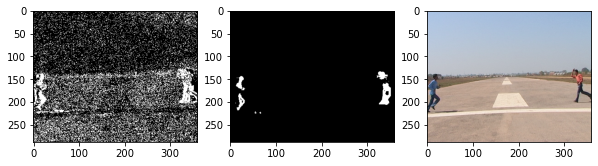

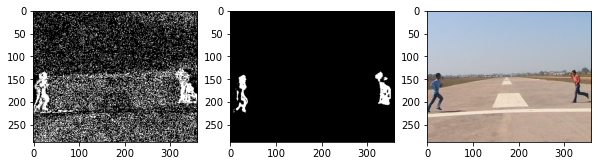

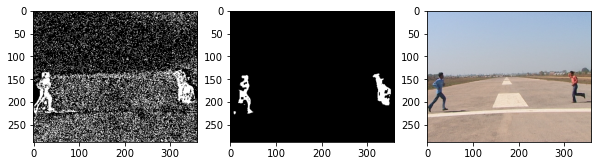

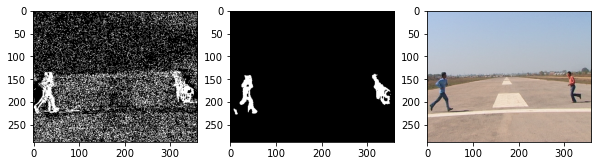

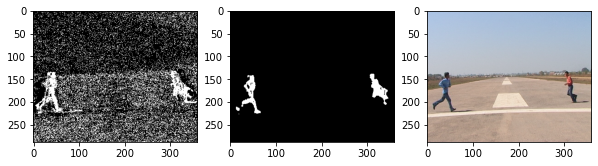

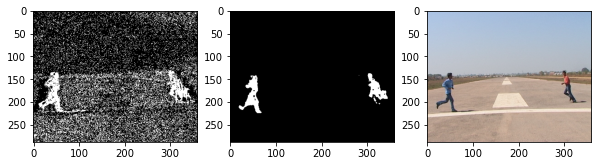

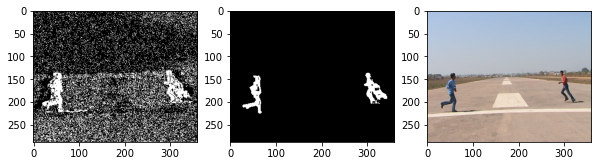

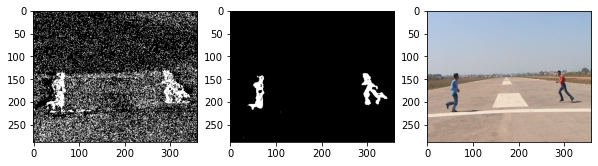

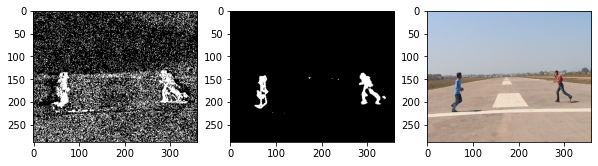

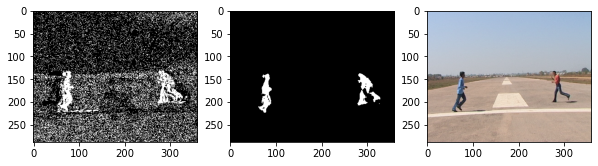

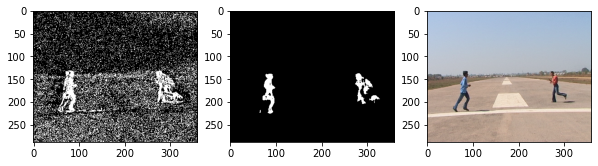

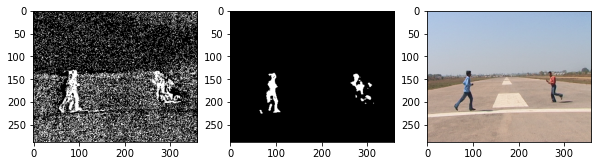

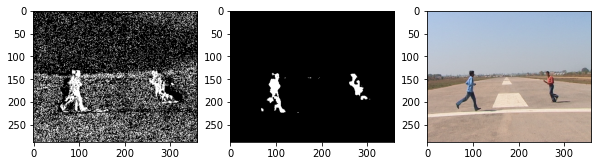

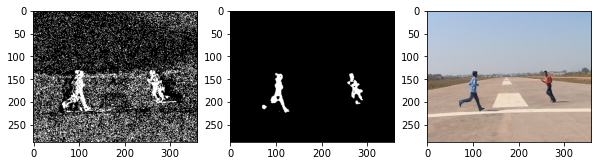

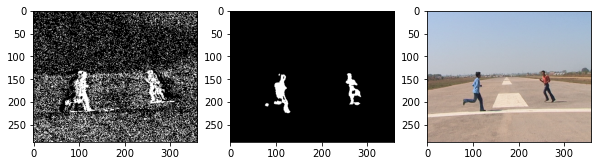

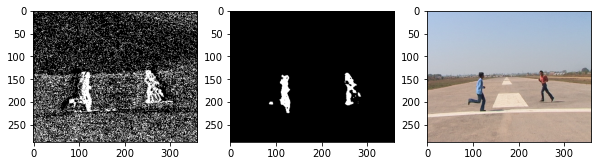

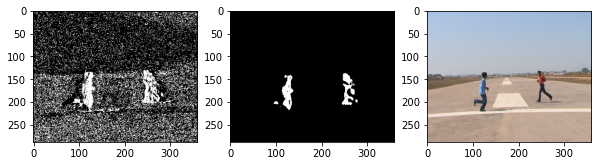

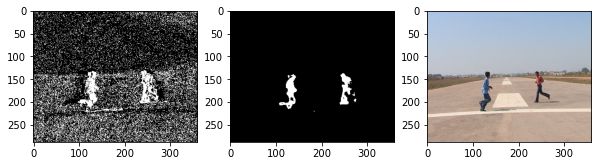

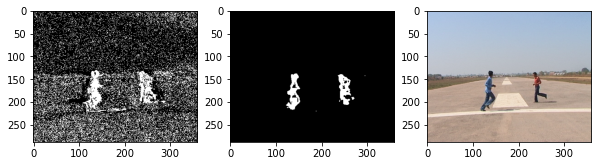

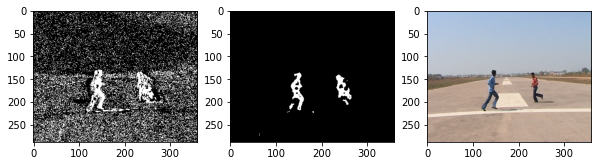

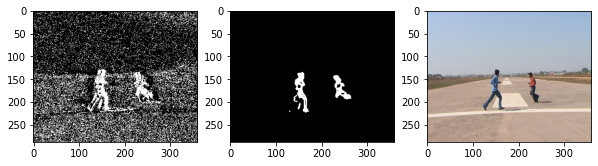

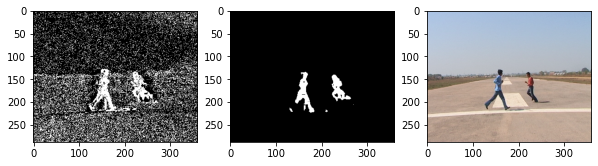

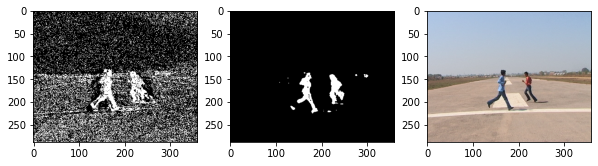

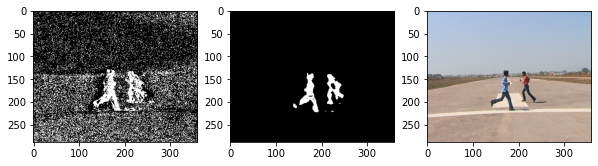

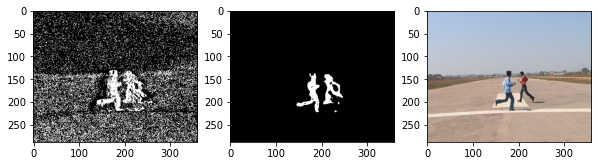

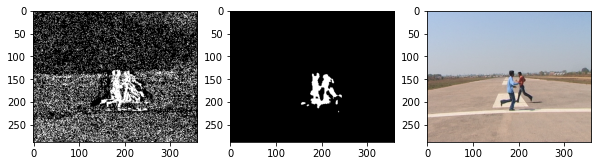

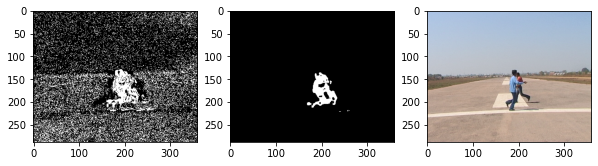

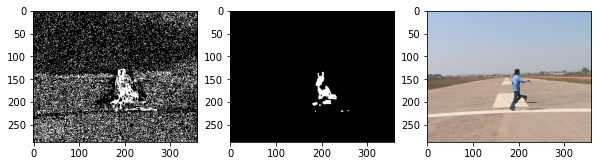

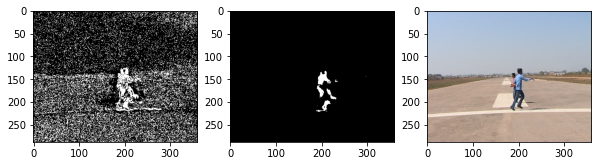

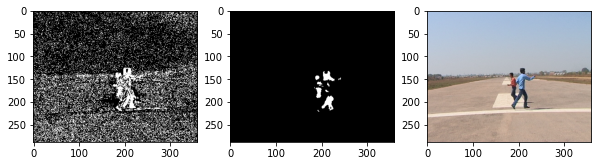

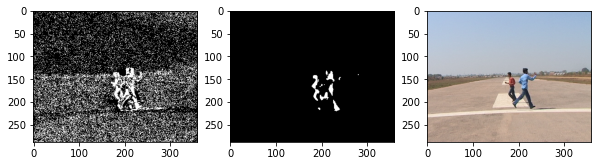

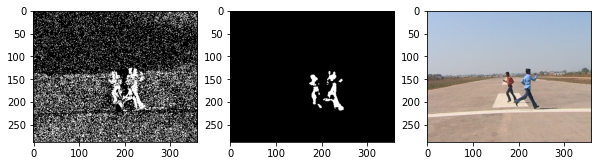

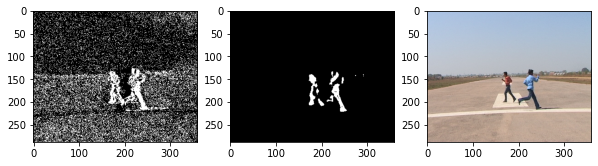

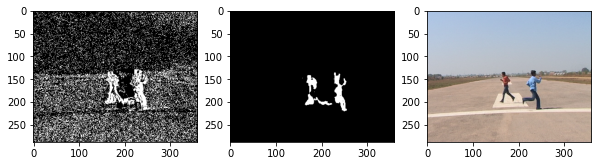

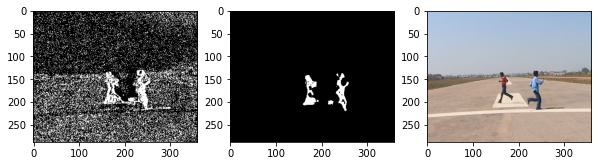

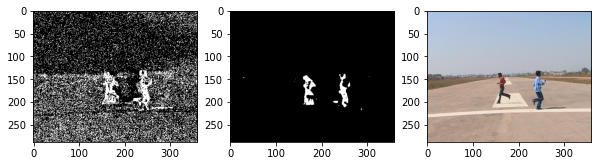

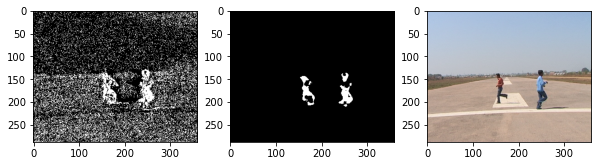

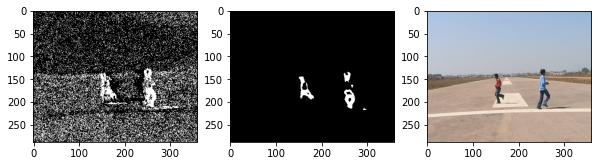

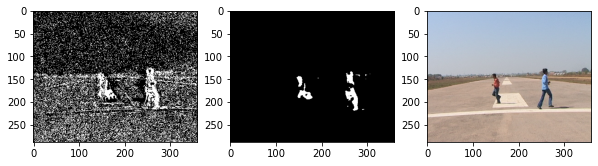

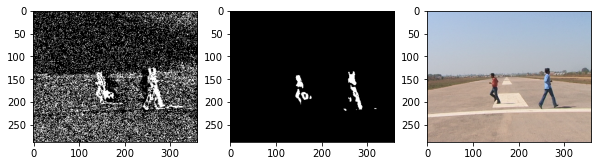

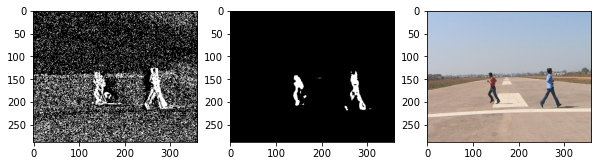

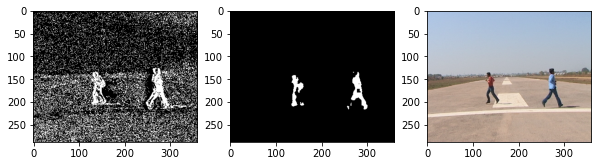

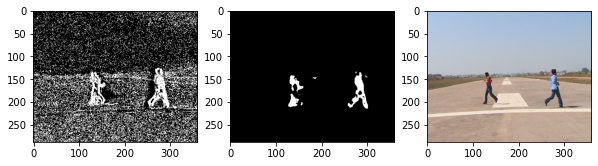

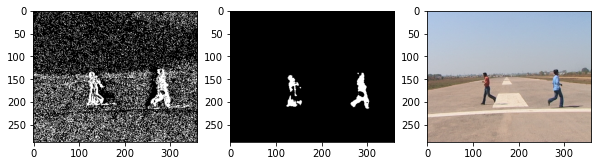

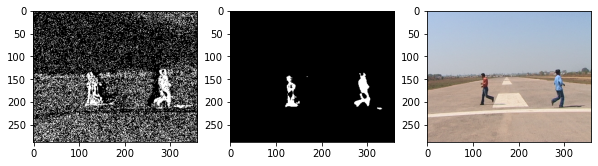

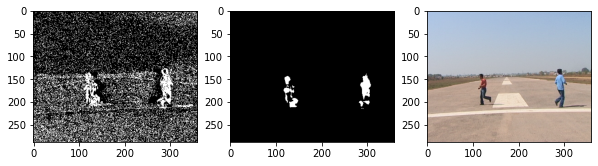

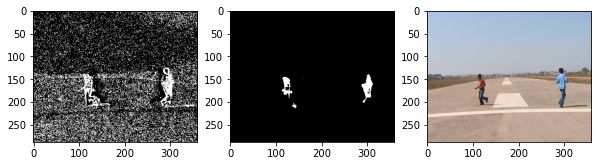

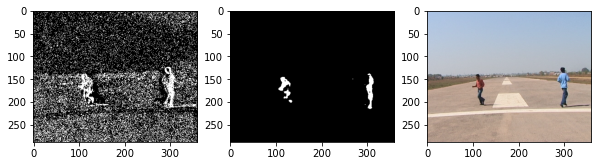

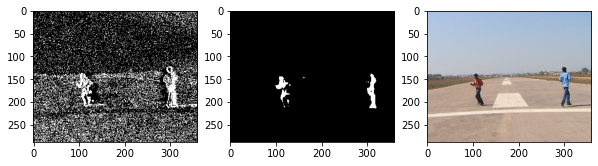

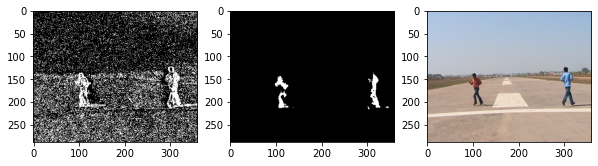

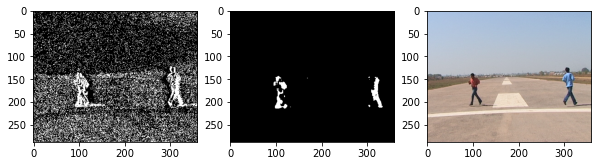

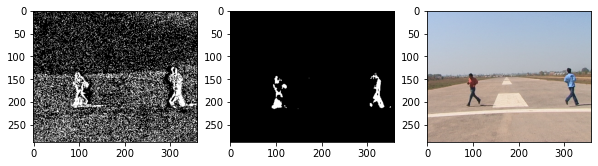

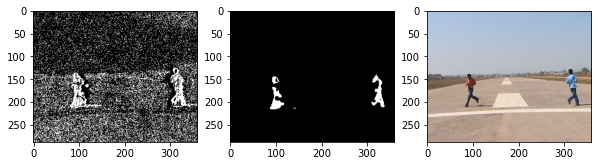

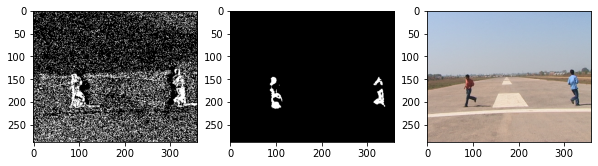

In [37]:
Background_Subtraction("./Images",0.8,0.7,8,8,0.8)